In [4]:
# for autoreloading edited the modules and packages instead of restarting the kernel
%reload_ext autoreload
%autoreload 2

## Neural Network model

### 1. hyperparameter tuning

In [5]:
from pathlib import Path
import torch
from neural_network.params_utils import param_generator

In [6]:
# log_version = 3
# params = {
#     "data_path": Path("data_preprocess") / "cleaned_ico_dataset.csv",
#     "target_feature": "Total amount raised (USDm)",
#     "drop_feature_list": None,
#     "log_path": Path("neural_network") / "logs" / f"log_v{log_version}.csv",
#     "epochs": 10,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "params": param_generator(),
# }


In [7]:
# from neural_network.params_utils import tune_hyperparameters


In [8]:
# tune_hyperparameters(**params)


In [9]:
from neural_network.train_utils import run

In [10]:
param_dict = {
    "data_path": r"data_preprocess\\cleaned_ico_dataset.csv",
    "epochs": 100,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 128,
    "hidden_layers": 8,
    "layer_units": 64,
    "learning_rate": 1,
    "normalize": True,
    "one_hot_encode": False,
    "test_size": 0.2,
}
train_losses, val_losses, model = run(
    target_feature="Total amount raised (USDm)", drop_features_list=None, **param_dict
)


(train_loss**0.5, val_loss**0.5)=(24.906760331385495, 47.060411951521154)
(train_loss**0.5, val_loss**0.5)=(22.140758010583177, 45.7312974066995)
(train_loss**0.5, val_loss**0.5)=(22.358521941710922, 44.089169400187586)
(train_loss**0.5, val_loss**0.5)=(22.086679495406557, 43.19040273801432)
(train_loss**0.5, val_loss**0.5)=(18.119571056888862, 42.08606149624392)
(train_loss**0.5, val_loss**0.5)=(18.586020829862587, 41.50324723741505)
(train_loss**0.5, val_loss**0.5)=(16.704661028384926, 40.795723006523616)
(train_loss**0.5, val_loss**0.5)=(16.747096479047215, 40.55469728255517)
(train_loss**0.5, val_loss**0.5)=(15.967010343565368, 39.19787791210769)
(train_loss**0.5, val_loss**0.5)=(16.98529538746424, 39.6031368361854)
(train_loss**0.5, val_loss**0.5)=(17.08863968972699, 39.663075345949125)
(train_loss**0.5, val_loss**0.5)=(17.464599989911513, 39.69460443301772)
Epoch    12: reducing learning rate of group 0 to 5.0000e-01.
(train_loss**0.5, val_loss**0.5)=(16.85349876234091, 39.837795

In [11]:
torch.save(model.state_dict(), r'neural_network\\ico_model.pt')


In [12]:
import pandas as pd
from neural_network.params_utils import find_best_hyperparameter

In [13]:
# log_path independant
log_path = Path("neural_network") / "logs" / f"log_v3.csv"
log_df = pd.read_csv(log_path)

# log_df = pd.read_csv(params["log_path"])
best_hyperparameter, min_val_loss_idx = find_best_hyperparameter(log_df, "val_loss")
best_hyperparameter[0][:-2], min_val_loss_idx


(array([32, 4, 16, 0.0475500468641555, True, False, 10,
        'data_preprocess\\cleaned_ico_dataset.csv', 'cuda'], dtype=object),
 (array([0], dtype=int64),))

In [14]:
best_params = log_df.iloc[min_val_loss_idx].to_dict(orient="records")[0]
best_params['data_path'] = 'data_preprocess\\cleaned_ico_dataset.csv'

### 2. training and validating the model

In [15]:
from neural_network.train_utils import run_with_kfold


In [16]:
best_params.keys()

dict_keys(['batch_size', 'hidden_layers', 'layer_units', 'learning_rate', 'normalize', 'one_hot_encode', 'epochs', 'data_path', 'device', 'val_loss', 'train_time'])

In [17]:
# best_params["learning_rate"] = 1e-7
best_params["epochs"] = 100
mean_val_loss, folds_val_losses, folds_train_losses = run_with_kfold(
    target_feature="Total amount raised (USDm)", drop_features_list=None, **best_params
)
mean_val_loss


20.57218312741576

In [18]:
import numpy as np


In [19]:
val_losses = np.concatenate([a[None] for a in folds_val_losses], axis=0)
train_losses = np.concatenate([a[None] for a in folds_train_losses], axis=0)
folds_mean_val_losses = val_losses.mean(axis=0)**0.5
folds_mean_train_losses = train_losses.mean(axis=0)**0.5

In [20]:
from matplotlib import pyplot as plt


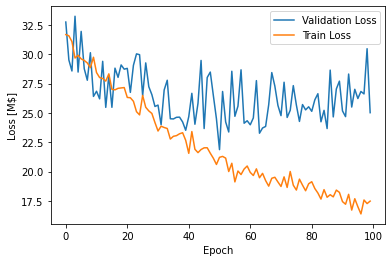

In [21]:
step = 1
# fold = 0

plt.plot(folds_mean_val_losses[::step], label="Validation Loss")
plt.plot(folds_mean_train_losses[::step], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss [M$]")
plt.legend()
plt.show()
